
# Semana 8 — CNN básica (PyTorch + MNIST) 🧠🖼️

Neste notebook você vai:
1) Carregar o **MNIST** (dígitos 28×28) com `torchvision`.  
2) Construir uma **CNN simples** (duas Convs + MaxPool + FC).  
3) Treinar e avaliar (loss e acurácia).  
4) Visualizar **amostras**, **filtros** e **mapas de ativação** (bônus).

> Observação: caso o ambiente não tenha internet, rode localmente.  
> Instalação CPU: `pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu`


In [1]:

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, classification_report


## 1) Configurações e carregamento do MNIST

In [2]:

BATCH_SIZE = 128
EPOCHS = 5
LR = 1e-3
WEIGHT_DECAY = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [3]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_ds = datasets.MNIST(root="data", train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root="data", train=False, download=True, transform=transform)
len(train_ds), len(test_ds)


(60000, 10000)

/Users/yandrade/PycharmProjects/ia_study/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


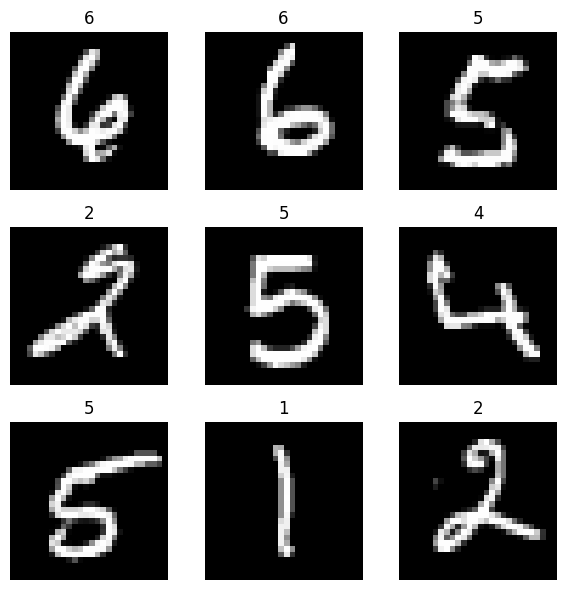

In [4]:

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

images, labels = next(iter(train_loader))
fig = plt.figure(figsize=(6,6))
for i in range(9):
    ax = plt.subplot(3,3,i+1)
    img = images[i].squeeze().numpy()
    plt.imshow(img, cmap="gray")
    plt.title(int(labels[i]))
    plt.axis("off")
plt.tight_layout(); plt.show()


## 2) Definir a CNN

In [5]:

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.pool  = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.flatten = nn.Flatten()
        self.fc1   = nn.Linear(32*7*7, 128)
        self.fc_out= nn.Linear(128, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x)); x = self.pool(x)
        x = F.relu(self.conv2(x)); x = self.pool(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc_out(x)
        return x

model = SimpleCNN().to(device)
model


SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)

## 3) Treino e avaliação

In [6]:

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

train_losses, val_losses = [], []
train_accs,   val_accs   = [], []

def accuracy(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            pred = logits.argmax(1)
            correct += (pred == yb).sum().item()
            total += yb.size(0)
    return correct / total

for epoch in range(1, EPOCHS+1):
    model.train(); running_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    tr_loss = running_loss / len(train_loader.dataset)
    tr_acc  = accuracy(model, train_loader)

    model.eval(); run_val = 0.0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            run_val += criterion(model(xb), yb).item() * xb.size(0)
    va_loss = run_val / len(test_loader.dataset)
    va_acc  = accuracy(model, test_loader)

    train_losses.append(tr_loss); val_losses.append(va_loss)
    train_accs.append(tr_acc);    val_accs.append(va_acc)
    print(f"Epoch {epoch:02d}/{EPOCHS} | train_loss={tr_loss:.4f} val_loss={va_loss:.4f} | train_acc={tr_acc:.3f} val_acc={va_acc:.3f}")


Epoch 01/5 | train_loss=0.2133 val_loss=0.0774 | train_acc=0.975 val_acc=0.974
Epoch 02/5 | train_loss=0.0592 val_loss=0.0446 | train_acc=0.986 val_acc=0.987
Epoch 03/5 | train_loss=0.0411 val_loss=0.0412 | train_acc=0.990 val_acc=0.986
Epoch 04/5 | train_loss=0.0321 val_loss=0.0362 | train_acc=0.992 val_acc=0.988
Epoch 05/5 | train_loss=0.0248 val_loss=0.0313 | train_acc=0.995 val_acc=0.990


## 4) Curvas de loss e acurácia

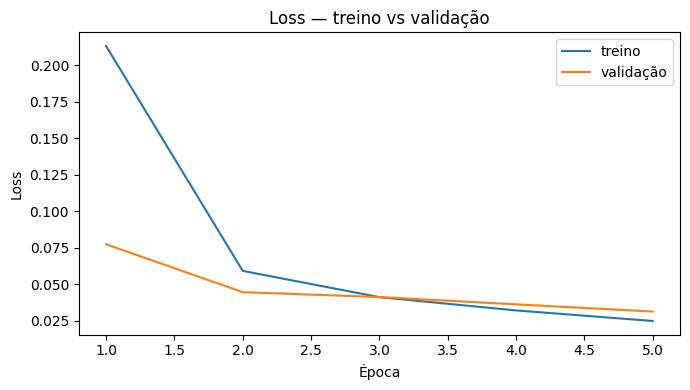

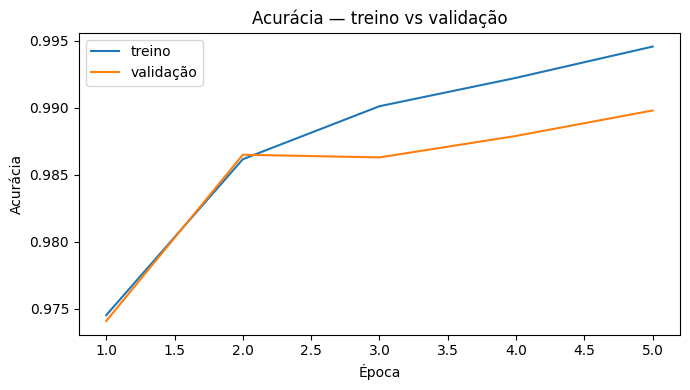

In [7]:

plt.figure(figsize=(7,4))
plt.plot(range(1,len(train_losses)+1), train_losses, label="treino")
plt.plot(range(1,len(val_losses)+1),   val_losses,   label="validação")
plt.xlabel("Época"); plt.ylabel("Loss"); plt.title("Loss — treino vs validação")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(7,4))
plt.plot(range(1,len(train_accs)+1), train_accs, label="treino")
plt.plot(range(1,len(val_accs)+1),   val_accs,   label="validação")
plt.xlabel("Época"); plt.ylabel("Acurácia"); plt.title("Acurácia — treino vs validação")
plt.legend(); plt.tight_layout(); plt.show()


## 5) Métricas detalhadas e matriz de confusão

              precision    recall  f1-score   support

           0     0.9819    0.9980    0.9899       980
           1     0.9965    0.9974    0.9969      1135
           2     0.9941    0.9855    0.9898      1032
           3     0.9882    0.9941    0.9911      1010
           4     0.9928    0.9857    0.9893       982
           5     0.9865    0.9865    0.9865       892
           6     0.9958    0.9875    0.9916       958
           7     0.9941    0.9893    0.9917      1028
           8     0.9857    0.9887    0.9872       974
           9     0.9812    0.9841    0.9827      1009

    accuracy                         0.9898     10000
   macro avg     0.9897    0.9897    0.9897     10000
weighted avg     0.9898    0.9898    0.9898     10000



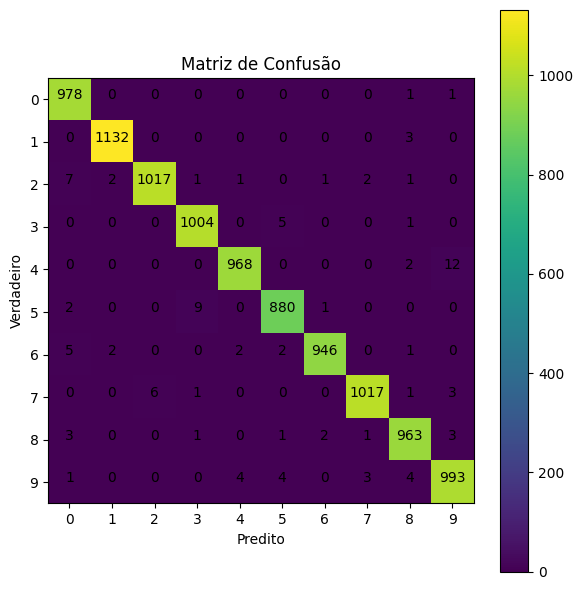

In [8]:

all_preds, all_targets = [], []
model.eval()
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        pred = logits.argmax(1).cpu().numpy()
        all_preds.append(pred)
        all_targets.append(yb.numpy())

y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_targets)

print(classification_report(y_true, y_pred, digits=4))
cm = confusion_matrix(y_true, y_pred)

import itertools
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation="nearest")
plt.title("Matriz de Confusão")
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center")
plt.ylabel("Verdadeiro"); plt.xlabel("Predito")
plt.tight_layout(); plt.show()


## 6) Visualizar filtros e ativações (bônus)

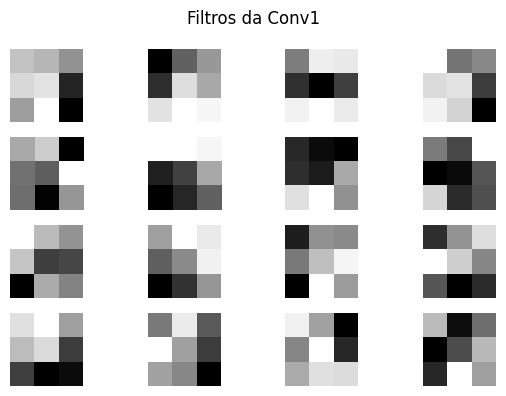

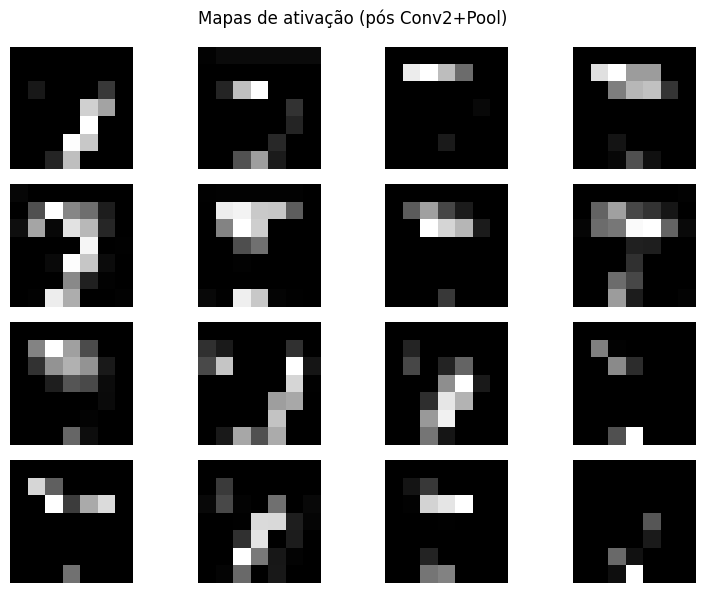

In [9]:

with torch.no_grad():
    w = model.conv1.weight.cpu().numpy()  # (16,1,3,3)
fig = plt.figure(figsize=(6,4))
for i in range(min(16, w.shape[0])):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(w[i,0], cmap="gray")
    plt.axis("off")
plt.suptitle("Filtros da Conv1"); plt.tight_layout(); plt.show()

img, label = test_ds[0]
model.eval()
with torch.no_grad():
    x = img.unsqueeze(0).to(device)  # (1,1,28,28)
    a1 = F.relu(model.conv1(x))
    p1 = model.pool(a1)
    a2 = F.relu(model.conv2(p1))
    p2 = model.pool(a2)

acts = p2.squeeze(0).cpu().numpy()  # (32,7,7)
fig = plt.figure(figsize=(8,6))
for i in range(min(16, acts.shape[0])):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(acts[i], cmap="gray")
    plt.axis("off")
plt.suptitle("Mapas de ativação (pós Conv2+Pool)"); plt.tight_layout(); plt.show()


## 7) Salvar/Carregar o modelo

In [10]:

save_path = "cnn_mnist.pt"
torch.save(model.state_dict(), save_path)
save_path


'cnn_mnist.pt'